In [2]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load general packages
import numpy as np

# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate

#  Exercise 3: Demand function

#### 1. Find the equilibrium distirbution of mileage

In [25]:
# Setup
do_settings = {
    'n': 90
}

model = zurcher(**do_settings)
solver = solve_NFXP()

#Read the data
data = model.read_busdata(bustypes=[1,2,3,4])
samplesize = data.shape[0]
uncond_R_P = sum(data.d)/samplesize

# Estimate
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data)



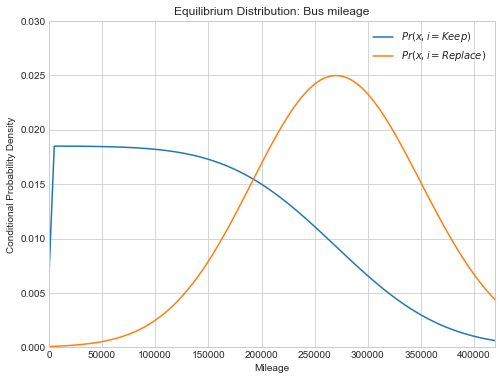

In [26]:
# Update the values with the estimated parameters
do_settings = {
    'n': 90,
    'RC': theta_hat[0],
    'c': theta_hat[1],
    'p': np.array(theta_hat[2:])
}

model_est = zurcher(**do_settings)
ev,pk = solver.poly(model_est.bellman, beta = model_est.beta, output=2)

# Find the probability functions
pp, pp_K, pp_R = model_est.eqb(pk)

fig = plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(1,1,1)

ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_K/sum(pp_K))
ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_R/sum(pp_R))


ax.set_title(f'Equilibrium Distribution: Bus mileage')
ax.set_xlabel("Mileage")
ax.set_ylabel("Conditional Probability Density")
ax.set_xlim(0, 420000)
ax.set_ylim(0, 0.03)

plt.legend((f'$Pr(x, i=Keep)$',f'$Pr(x, i=Replace)$'))

plt.show()

#### 2. Find the scale of the cost function
a) How does the scale of the cost function relates to the estimate of RC and c?

b) What is the scale estimate? Hint: Use the stuctural estimates and tabel III in  Rust (1987), "Optimal Replacement of GMC Bus Engines: An Emperical Model of Harold Zurcher

the scale relates the estimates to actual $ costs of replacement and upkeep. In table III Rust has data on the costs of replacement for different bus groups. This fixes $RC to the data value, while the implied $c, how much upkeep costs increase when moving to next milage bracket, can be calculated from the implied scale. <br>
For bus group 1,2,3,4 we have:
\begin{align}
\$RC = 8062
\end{align}
$$
\$RC = scale ⋅ RC ⇔ scale = \frac{\$RC}{RC}
$$
$$
\$c = scale ⋅ c 
$$

In [27]:
model.RC

9.952960129628735

In [28]:
scale = 8062 / model.RC
print(f"Scale: {scale}")
dolc = scale *model.c
print(f"$c   : {dolc}")

Scale: 810.0102778469312
$c   : 2123.639518121427


In [29]:
model.RC_scale = scale

In [30]:
model.RC_scale

810.0102778469312

#### 3. Find the implied Demand function

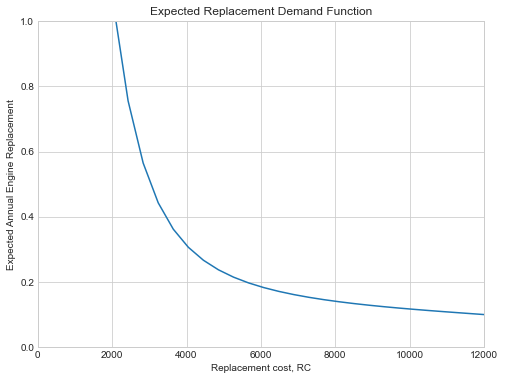

In [92]:
# Expected Demand, as a function of Replacement cost
import copy
mp0 = copy.copy(model_est.RC)
NRC = 59

RCgrid = np.linspace(1,30,NRC)

Demand = np.empty(NRC)

for i,val in enumerate(RCgrid):
    do_settings = {
        'n': 90,
        'RC': val,
        'c': theta_hat[1],
        'p': np.array(theta_hat[2:])
    }
    
    model_i = zurcher(**do_settings)
    _,pk = solver.poly(model_i.bellman, beta= model_i.beta, output=2)

    # Find the probability functions
    pp, pp_K, pp_R = model_i.eqb(pk)
    
    Demand[i] = 12*sum(pp_R)

fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale,Demand)
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

#### 4. Try estimate the demand function for different values of $\beta$. Does the change in the demand function makes intuitively sense?

In [54]:
def demand_function(settings,NRC =58, interval=[1,30],scale=scale, plot=False):
    # Expected Demand, as a function of Replacement cost

    do_settings = copy.copy(settings)
    RCgrid = np.linspace(1,30,NRC)

    Demand = np.empty(NRC)

    for i,val in enumerate(RCgrid):
        do_settings['RC'] = val
        
        model_i = zurcher(**do_settings)
        _,pk = solver.poly(model_i.bellman, beta= model_i.beta, output=2)

        # Find the probability functions
        pp, pp_K, pp_R = model_i.eqb(pk)
        
        Demand[i] = 12*sum(pp_R)

    RCgrid_scaled  =RCgrid*scale

    if plot:
        fig = plt.figure(figsize=(8,6)) 
        ax2 = fig.add_subplot(1,1,1)
        ax2.plot(RCgrid_scaled,Demand)
        ax2.set_title(f'Expected Replacement Demand Function')
        ax2.set_xlabel("Replacement cost, RC")
        ax2.set_ylabel("Expected Annual Engine Replacement")
        ax2.set_xlim(0,12000)
        ax2.set_ylim(0,1)

        plt.show()
        
    return RCgrid_scaled, Demand


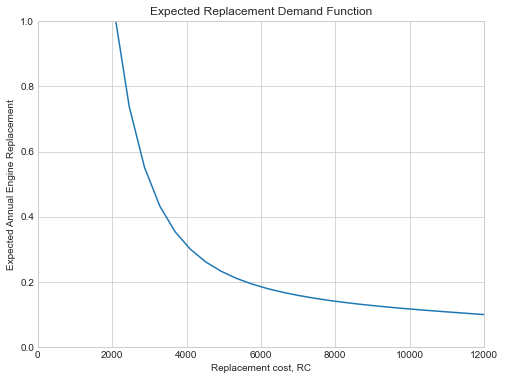

In [94]:
# Make sure it works
grid, demand = demand_function({'n':90,'c': theta_hat[1],'p': np.array(theta_hat[2:]) } ,plot=True)

In [95]:
NRC =58
beta_vec = [0,0.5,0.75, 0.9, 0.9999]

RC_data = 8062
scale_vec = np.empty(len(beta_vec))
demand_vecs = np.empty((len(beta_vec),NRC))
grid_vecs = np.empty((len(beta_vec),NRC))


for i,β in enumerate(beta_vec):
    settings = {
            'n': 90,
            'beta':β
        }


    # estimate parameters
    model_j = zurcher(**settings)
    solver_j = solve_NFXP()

    # Estimate
    _, _, _, theta_hat,_, _=estimate.estimate(model_j, solver,data)
    scale_vec[i] = RC_data/copy.copy(theta_hat[0])
    

    settings.update({'RC': val,
            'c': theta_hat[1],
            'p': np.array(theta_hat[2:])})
        
    grid_vecs[i], demand_vecs[i] = demand_function(settings,scale= scale_vec[i], NRC=NRC)

c:\Users\Asker\OneDrive - Københavns Universitet\Documents\Uni\10. semester\Dynamic Programming\dp_ucph\2_dynamic_discrete_choice\exercises\work\Solve_NFXP.py:91: RuntimeWarning: invalid value encountered in double_scalars
  iteration.rtol[i] = iteration.tol[i]/iteration.tol[max(i-1,0)]
c:\Users\Asker\OneDrive - Københavns Universitet\Documents\Uni\10. semester\Dynamic Programming\dp_ucph\2_dynamic_discrete_choice\exercises\work\model_zucher.py:72: RuntimeWarning: overflow encountered in exp
  pk = 1/(1+np.exp(value_replace-value_keep))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


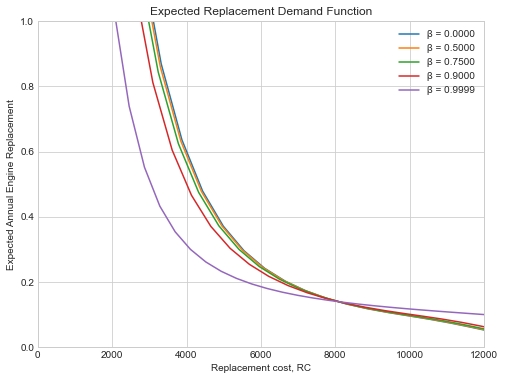

In [96]:


fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)

for i, β in enumerate(beta_vec):
    ax2.plot(grid_vecs[i],demand_vecs[i],label = f'β = {β:0.4f}')
ax2.legend()
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1);

#### 5. Now introduce five buses (M=5) instead of one bus, what is the combined demand?

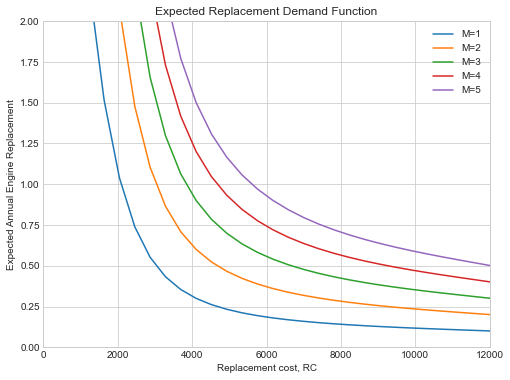

In [97]:
# Setup
fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)


for i in range(1,6):
    ax2.plot(grid,demand*i, label= f"M={i}")


ax2.legend()
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")

ax2.set_xlim(0,12000)
ax2.set_ylim(0,2)

plt.show()

#### 6. What are the advantage and disadvantage of using a structual model to estimate the demand?

In [ ]:
## You can include behavorial adjustments to policy interventions